# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [3]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

1. Plot histograms of mu, sigma and simulated height.

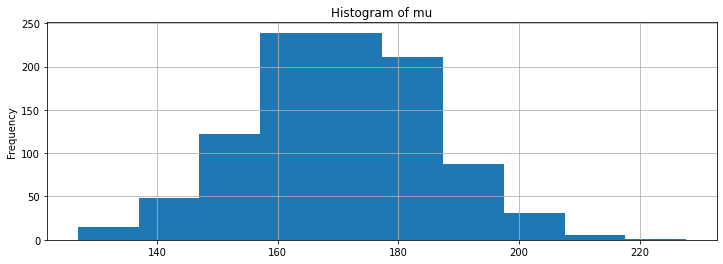

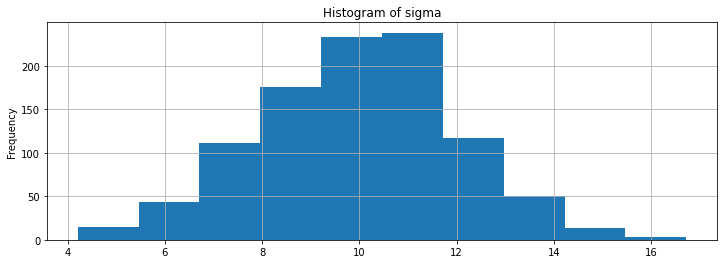

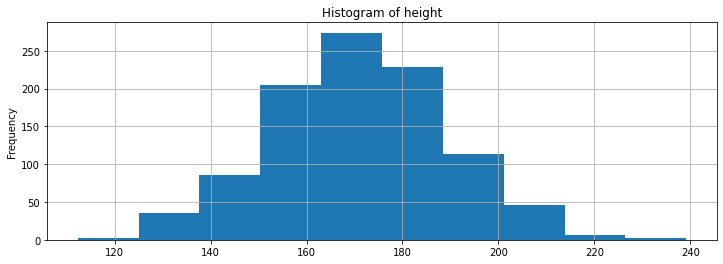

In [4]:
df = sim.draws_pd()

plt.rcParams["figure.figsize"] = (12,4)

df["mu"].plot.hist()
plt.title("Histogram of mu")
plt.grid()
plt.show()

df["sigma"].plot.hist()
plt.title("Histogram of sigma")
plt.grid()
plt.show()

df["height"].plot.hist()
plt.title("Histogram of height")
plt.grid()
plt.show()

2. Plot a joint distribution of mu and sigma.

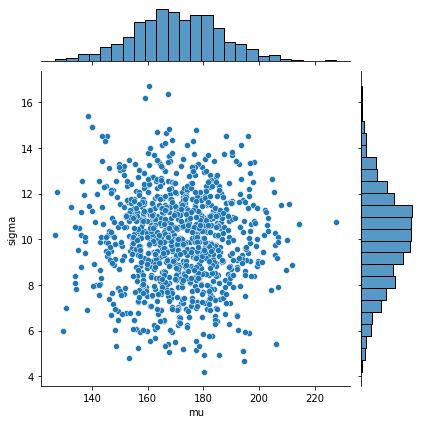

In [5]:
sns.jointplot(x=df["mu"], y=df["sigma"], data=df)
plt.show()

## Task 2. Model fit and evaluation

In [6]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [7]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


In [8]:
df2 = fit.draws_pd()
df2

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,height
0,-893.495,0.754510,0.570575,2.0,3.0,0.0,895.288,155.209,7.20391,147.660
1,-891.385,0.972783,0.570575,2.0,3.0,0.0,893.976,154.680,7.32872,155.830
2,-891.616,0.981552,0.570575,1.0,1.0,0.0,891.688,154.571,7.29146,140.866
3,-890.291,0.980619,0.570575,2.0,7.0,0.0,892.227,154.917,7.84888,146.646
4,-890.391,0.887563,0.570575,2.0,3.0,0.0,891.650,154.266,7.70826,162.988
...,...,...,...,...,...,...,...,...,...,...
3995,-890.217,0.947490,0.564157,2.0,3.0,0.0,892.382,154.663,7.98306,147.968
3996,-890.269,0.998489,0.564157,2.0,3.0,0.0,890.273,154.677,8.00454,137.662
3997,-890.496,0.969905,0.564157,2.0,7.0,0.0,890.756,154.197,7.79470,161.313
3998,-890.701,0.782935,0.564157,2.0,3.0,0.0,893.144,154.961,8.04799,166.331



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


1. Plot a joint distribution of fitted mu and sigma

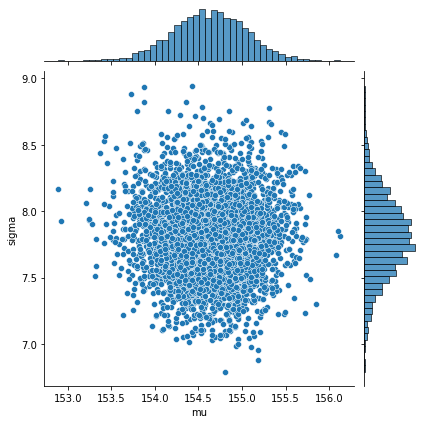

In [9]:
sns.jointplot(x=df2["mu"], y=df2["sigma"], data=df2)
plt.show()

2. Plot histograms of data and simulated heights and evaluate the quality of model.


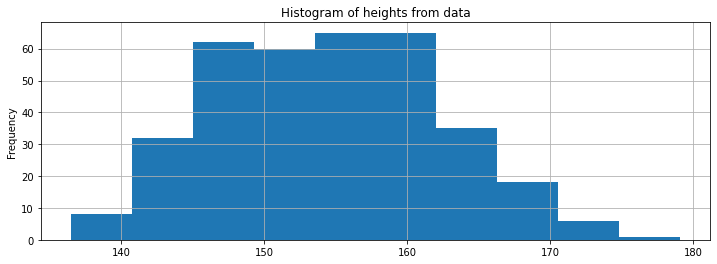

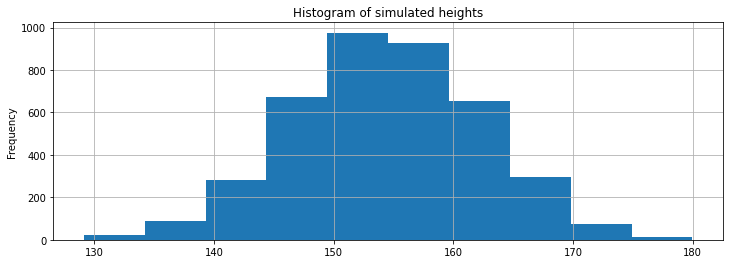

In [10]:
d["height"].plot.hist()
plt.title("Histogram of heights from data")
plt.grid()
plt.show()

df2["height"].plot.hist()
plt.title("Histogram of simulated heights")
plt.grid()
plt.show()

Quality of model is quite good. The most common simulated heights are between 150 and 160, same as heights from data. The appearance of histogram and the height distribution is similar for both cases.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [11]:
d['c_weight'] = d['weight'] / d['weight'].mean()
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
d.head()


,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,1.063016
1,139.700,36.485807,63.0,0,0.810967
2,136.525,31.864838,65.0,0,0.708257
3,156.845,53.041914,41.0,1,1.178958
4,145.415,41.276872,51.0,0,0.917458


## Task 4. Prior predictive checks
 

In [12]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

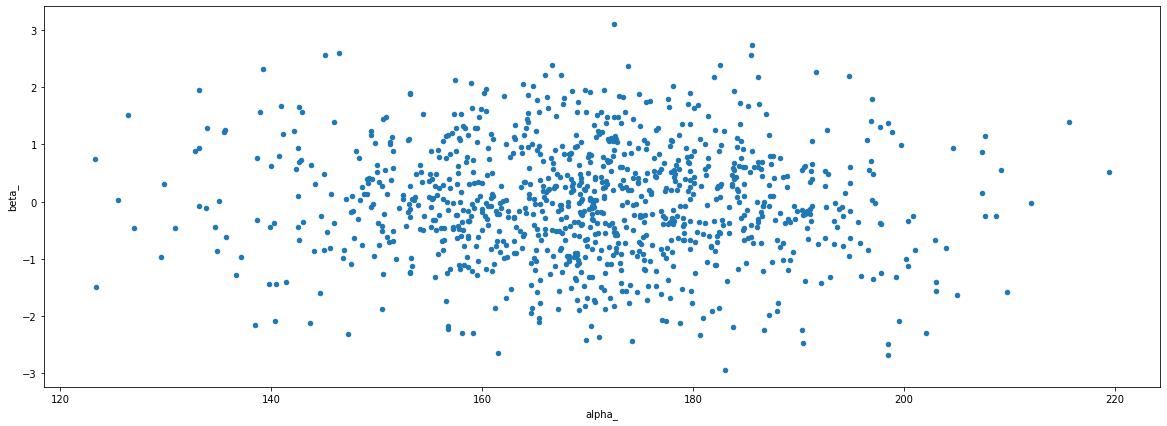

Minimum values of predicted heights: 15.0

Maximum values of predicted heights: 261.895


In [13]:
df4 = sim.draws_pd()
#df4

plt.rcParams["figure.figsize"] = (20,7)

df4.plot.scatter('alpha_', 'beta_')
plt.show()

df4_heights = df4.drop(['lp__', 'accept_stat__', 'mu', 'sigma', 'alpha_', 'beta_'], axis=1)

print("Minimum values of predicted heights: " + str(df4_heights.values.min()))

print("\nMaximum values of predicted heights: " + str(df4_heights.values.max()))

Minimum predicted height is consistent because is greater than 0, but maximum predicted height is not consistent because the tallest man in the world has 251cm.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [14]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [15]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

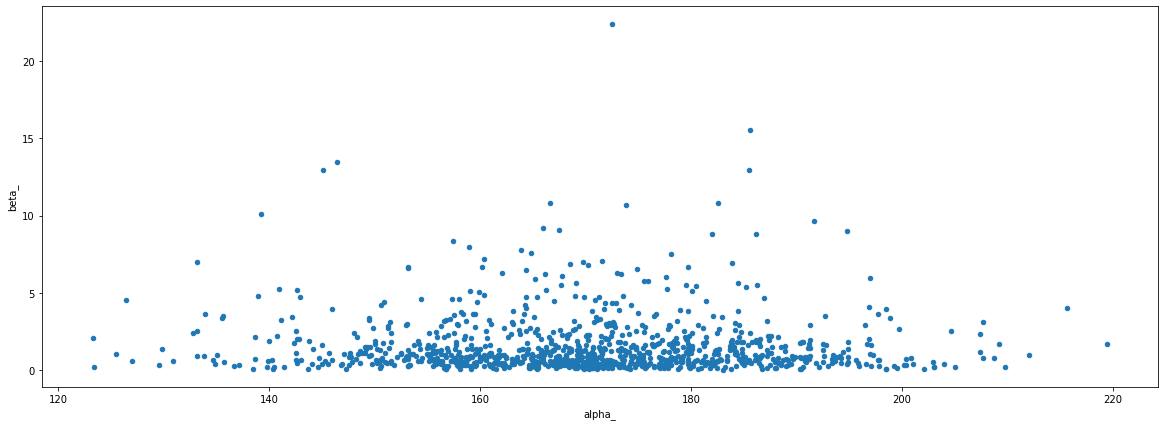

Minimum values of predicted heights: 15.0

Maximum values of predicted heights: 262.717


In [16]:
df5 = sim.draws_pd()
#df5

df5.plot.scatter('alpha_', 'beta_')
plt.show()

df5_heights = df5.drop(['lp__', 'accept_stat__', 'mu', 'sigma', 'alpha_', 'beta_'], axis=1)

print("Minimum values of predicted heights: " + str(df5_heights.values.min()))

print("\nMaximum values of predicted heights: " + str(df5_heights.values.max()))

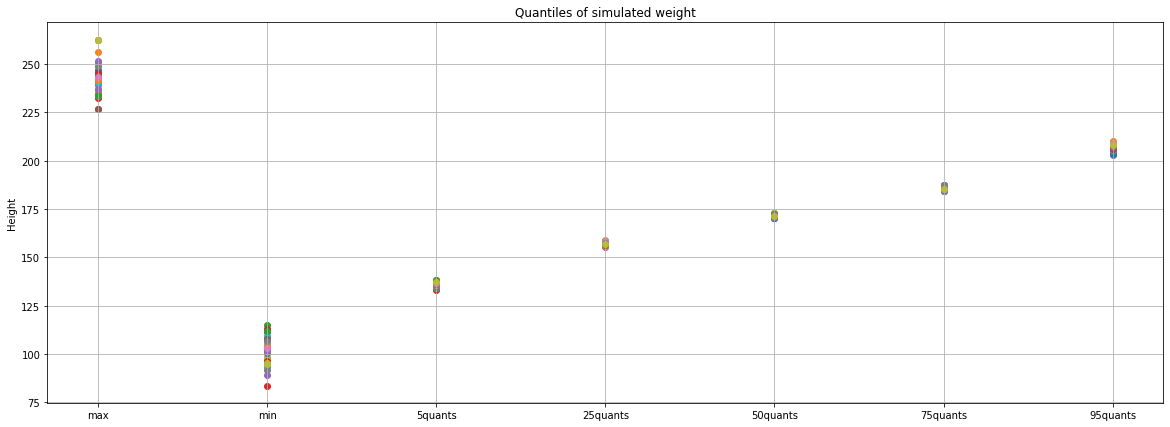

In [17]:
N = 50
params = []
for i in range(1,N):
    height = 'height['+ str(i)+']'
    data = df5[height]
    params.append([max(data), min(data), data.quantile(0.05), data.quantile(0.25), data.quantile(0.5), data.quantile(0.75), data.quantile(0.95)])

quants = ['max', 'min', '5quants', '25quants', '50quants', '75quants', '95quants']
for sample in params:
    plt.scatter(quants, sample)
plt.ylabel("Height")
plt.title("Quantiles of simulated weight")
plt.grid()
plt.show()

## Task 6. Fitting and evaluating model


In [18]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [19]:
N = 50
data_fit = {'N':N, 'heights':d.height.values[:N], 'weight': d.c_weight.values[:N]}

fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |▍         | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


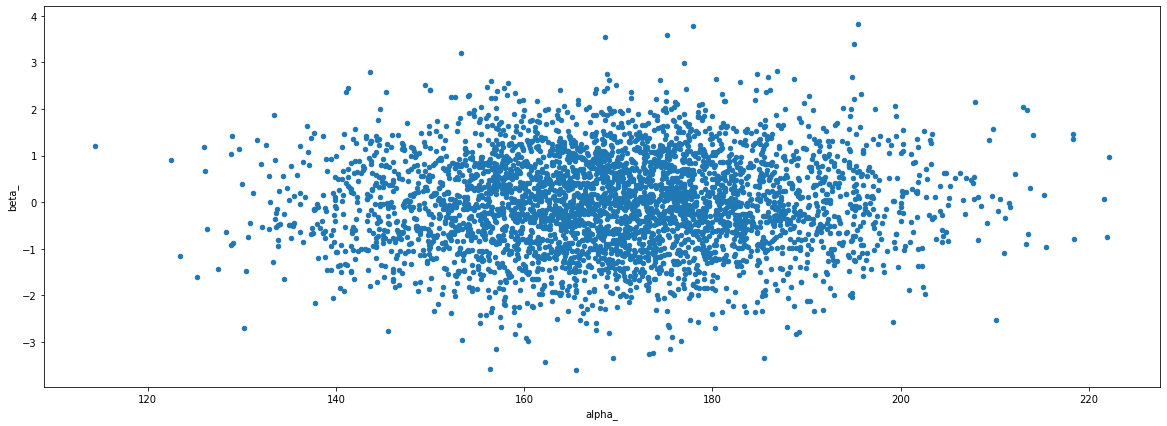

In [20]:
df6 = fit.draws_pd()
#df6

df6.plot.scatter('alpha_', 'beta_')
plt.show()

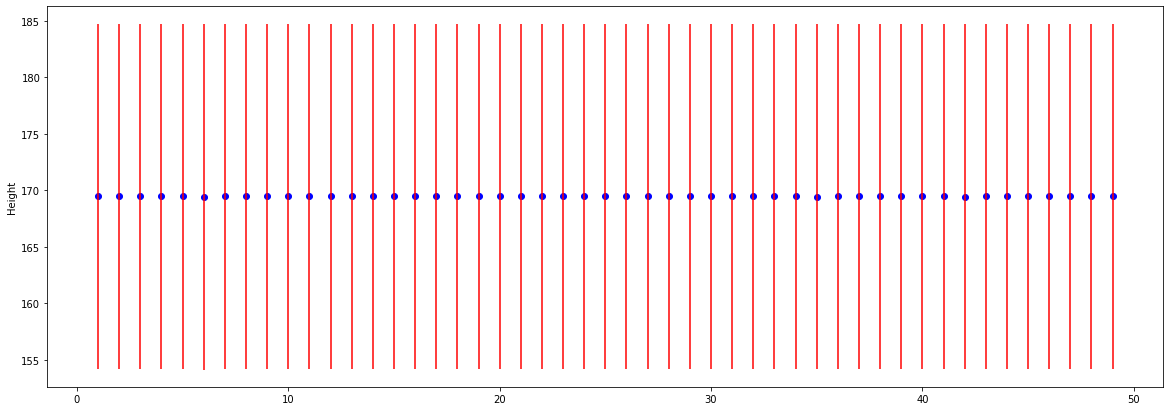

In [21]:
for i in range(1,N):
    mu_arr = 'mu_arr['+ str(i)+']'
    data = df6[mu_arr]
    plt.scatter(i, np.mean(data), color = 'b')
    plt.errorbar(i, np.mean(data), np.std(data), color='r')
plt.ylabel("Height")
plt.show()

All means and errorbars look really similar. I can't see any change when N increases.

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 